# Air polution in California

Our dataset is a series of meassures of air quality for various locations across the USA. Our original dataset had 1.7million rows<br>
To reduce the size of our dataset we decided to just focus on the state of California which took us down to 55,000 observations

** Target ** <br>The data doesn't have an obvious target, however we thought it could be interesting to predict which city an observation belongs to based on the composition of different pollutants in the sample.

** Feature matrix ** <br>We are going to just focus on the measurements of the different pollutants as our features and drop the other data.

** Aims of our project **
- Explore the patterns in air pollution across the state of California 
- Use clustering techniques to see if our model can predict the city based on the air pollution components 
- Use clustering predictions as a feature of a supervised learning technique to predict city based on pollution data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Essential modeling imports
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler


%config InlineBackend.figure_format = 'retina'

In [5]:
df = pd.read_csv('/Users/Hannah/Downloads/pollution_us_2000_2016.csv')

In [6]:
df.head(2)

,Unnamed: 0,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,...,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.0,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN
1,1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.0,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0


In [3]:
def scale_dataframe(df, method = 'StandardScaler', fit=True):
    if method == 'StandardScaler':
        scaler = StandardScaler()
        if fit: scaler.fit(df)
        return pd.DataFrame(columns=df.columns,data=scaler.transform(df))
    elif method == 'MinMaxScaler':
        scaler = MinMaxScaler()
        if fit: scaler.fit(df)
        return pd.DataFrame(columns=df.columns,data=scaler.transform(df))
    elif method == 'Mixed':
        df_mixed = df.copy()
        binary = df.applymap(lambda x:
            1 if x ==0 or x == 1
            else np.nan).dropna(how='any',axis = 1).columns
        for col in [col for col in df.columns if col not in binary]:
            std = df[col].std()
            xbar = df[col].std()
            df_mixed[col] = df[col].apply(lambda x:float(x-xbar)/std)
        return df_mixed


In [7]:
df_drop = df.drop([col for col in df.columns if 'Units' in col or col in ['Address', 'Unnamed: 0']], axis=1)

### Data Cleaning and Initial EDA

There were quite a few missing values for a couple of featues of our data. As we were missing alomost half of our observations and the features were aggregate features we decided to drop the columns.


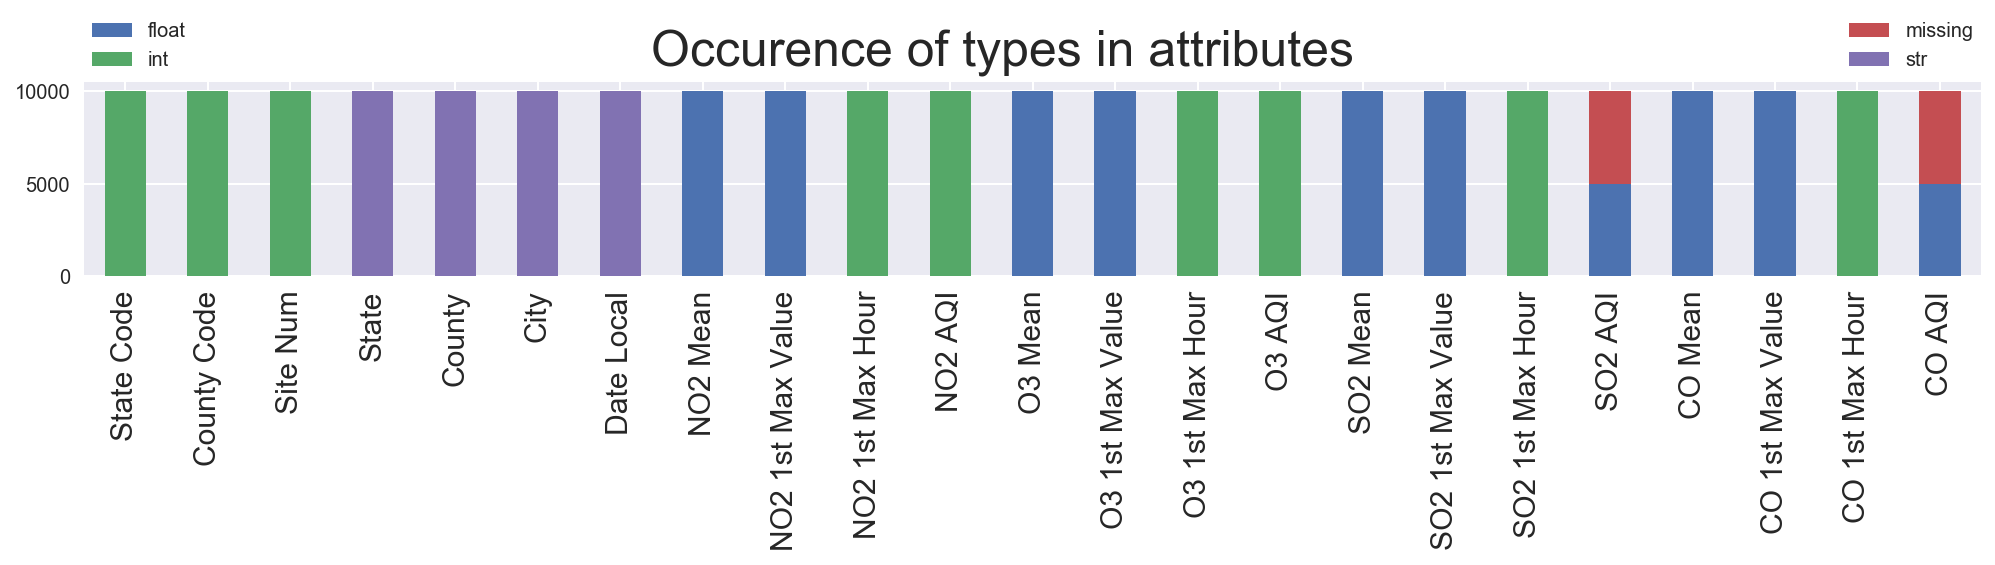

In [6]:
plot_types(df_drop.iloc[0:10000,:])

In [8]:
df_drop = df_drop.drop(['SO2 AQI','CO AQI'], axis=1)
df_drop.head(3)

,State Code,County Code,Site Num,State,County,City,Date Local,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,...,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,CO Mean,CO 1st Max Value,CO 1st Max Hour
0,4,13,3002,Arizona,Maricopa,Phoenix,2000-01-01,19.041667,49.0,19,...,0.0225,0.04,10,34,3.000,9.0,21,1.145833,4.2,21
1,4,13,3002,Arizona,Maricopa,Phoenix,2000-01-01,19.041667,49.0,19,...,0.0225,0.04,10,34,3.000,9.0,21,0.878947,2.2,23
2,4,13,3002,Arizona,Maricopa,Phoenix,2000-01-01,19.041667,49.0,19,...,0.0225,0.04,10,34,2.975,6.6,23,1.145833,4.2,21


In [9]:
df_california = df_drop[df['State'] == 'California']
df_california.head(3)

,State Code,County Code,Site Num,State,County,City,Date Local,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,...,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,CO Mean,CO 1st Max Value,CO 1st Max Hour
3516,6,13,2,California,Contra Costa,Concord,2000-01-01,14.782609,26.0,4,...,0.015542,0.029,13,25,0.636364,2.0,9,0.556522,1.3,4
3517,6,13,2,California,Contra Costa,Concord,2000-01-01,14.782609,26.0,4,...,0.015542,0.029,13,25,0.636364,2.0,9,0.572222,0.8,6
3518,6,13,2,California,Contra Costa,Concord,2000-01-01,14.782609,26.0,4,...,0.015542,0.029,13,25,0.600000,2.0,11,0.556522,1.3,4


####  We converted the date feature to months since the start of the data


In [10]:
def date_to_months(date):
    if type(date) == int: 
        return date
    else:
        return ((int(date.split('-')[0]) -2000)*12+int(date.split('-')[1]))

In [12]:
date = df_california['Date Local'].apply(lambda x: date_to_months(x))
df_california.loc[:,'Date Local'] = date

In [13]:
df_california.head(3)

,State Code,County Code,Site Num,State,County,City,Date Local,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,...,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,CO Mean,CO 1st Max Value,CO 1st Max Hour
3516,6,13,2,California,Contra Costa,Concord,1,14.782609,26.0,4,...,0.015542,0.029,13,25,0.636364,2.0,9,0.556522,1.3,4
3517,6,13,2,California,Contra Costa,Concord,1,14.782609,26.0,4,...,0.015542,0.029,13,25,0.636364,2.0,9,0.572222,0.8,6
3518,6,13,2,California,Contra Costa,Concord,1,14.782609,26.0,4,...,0.015542,0.029,13,25,0.600000,2.0,11,0.556522,1.3,4


#### We plotted some graphs to get our bearings of our data as it relates to the location of the cities.

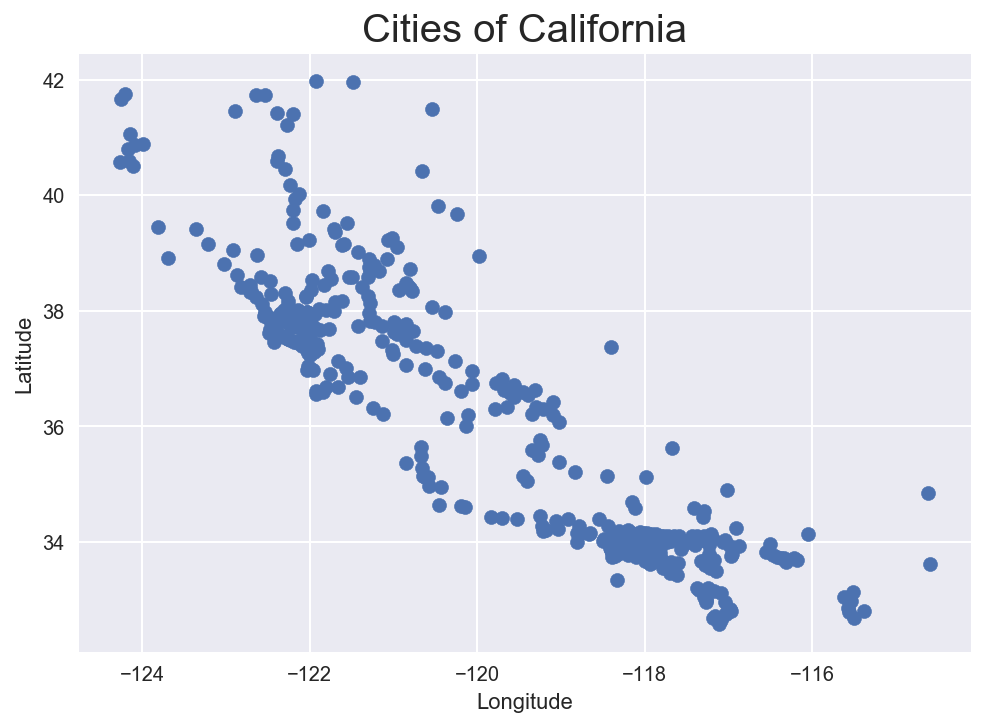

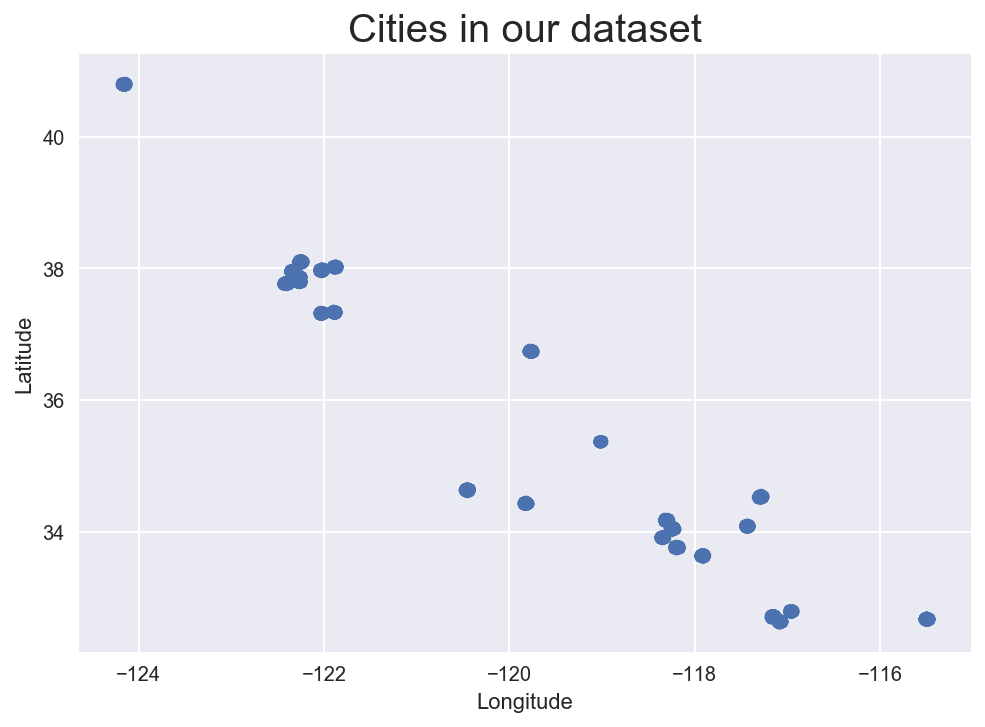

In [12]:
city_locations = pd.read_excel('./../../../../Downloads/cal cities (7).xlsx', encoding='utf8')
city_locations.columns = ['City','Latitude','Longitude']
df_california_wlocations = pd.merge(df_california, city_locations, on='City', how='left')

plt.scatter(city_locations['Longitude'],city_locations['Latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cities of California', size = 20)

helper = df_california_wlocations[['Latitude','Longitude']]
helper = helper + 0.01*np.random.normal(size=helper.shape)
helper.plot(kind = 'scatter', y='Latitude', x='Longitude')
plt.title('Cities in our dataset', size = 20)
plt.show()

<right><img src="https://files.slack.com/files-pri/T0351JZQ0-F6M94L5MH/pasted_image_at_2017_08_11_12_42_pm.png" style=" margin: 15px; height: 700px"></right>



We wanted to better understand the relationship between the the month and levels of pollutants in the dataset so we decided to plot the graph below. From this graph we can see that there is both a seasonal oscilation and a decrease over time in pollutant levels.


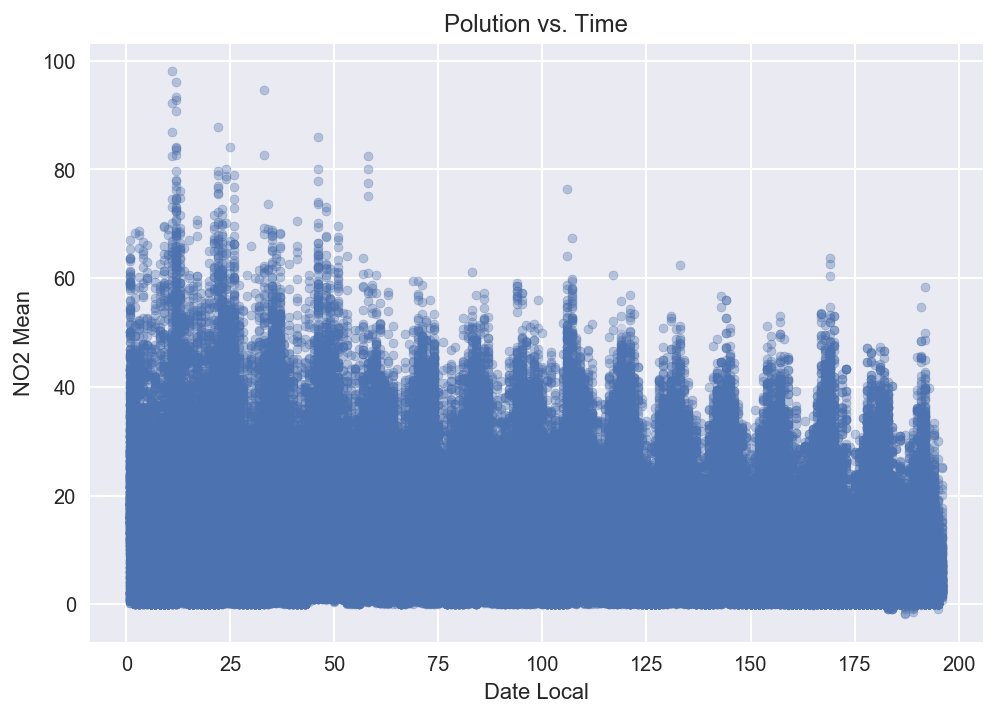

In [13]:
df_california.plot(kind='scatter', 
                   x = 'Date Local', 
                   y = 'NO2 Mean', 
                   title = 'Polution vs. Time',
                   alpha = 0.1)
plt.show()

#### Due to this non linear relationship we decided to create dummy variables for the four seasons and add a new feature for year (dropping the month feature)

In [14]:
df_X = df_california.drop(['Site Num','County Code',
                           'State','County','City','State Code'], axis=1)

def month_to_season(months):
    month = months%12
    if month in [11,12,1]:
        return 'winter'
    elif month in [2,3,4]:
        return 'spring'
    elif month in [5,6,7]:
        return 'summer'
    else: 
        return 'autumn'
    
def month_to_year(months):
    return int(months/12)

df_X['year'] = df_X['Date Local'].apply(month_to_year)
df_X['season'] = df_X['Date Local'].apply(month_to_season)
df_X = df_X.drop(['Date Local'], axis=1)

In [15]:
X = scale_dataframe(pd.get_dummies(df_X), method='Mixed')
X.head()

,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,CO Mean,CO 1st Max Value,CO 1st Max Hour,year,season_autumn,season_spring,season_summer,season_winter
3516,0.333939,0.442313,-0.457868,0.459434,0.348002,0.929748,2.502712,0.223548,-0.547499,-0.374479,0.423418,0.480641,0.627859,-0.447018,-1.0,0,0,0,1
3517,0.333939,0.442313,-0.457868,0.459434,0.348002,0.929748,2.502712,0.223548,-0.547499,-0.374479,0.423418,0.522411,0.001759,-0.170527,-1.0,0,0,0,1
3518,0.333939,0.442313,-0.457868,0.459434,0.348002,0.929748,2.502712,0.223548,-0.573356,-0.374479,0.739733,0.480641,0.627859,-0.447018,-1.0,0,0,0,1
3519,0.333939,0.442313,-0.457868,0.459434,0.348002,0.929748,2.502712,0.223548,-0.573356,-0.374479,0.739733,0.522411,0.001759,-0.170527,-1.0,0,0,0,1
3520,0.447716,0.664208,1.846195,0.634566,0.326319,1.129377,1.424955,0.321432,-0.288927,-0.374479,-0.209212,0.538478,0.377419,1.903155,-1.0,0,0,0,1


## Feature selection

##### As we have got aggregte measures as features in our data we are expecting to have highly correlated features, we've plotted a heatmap below to explore the redundancy in our data.

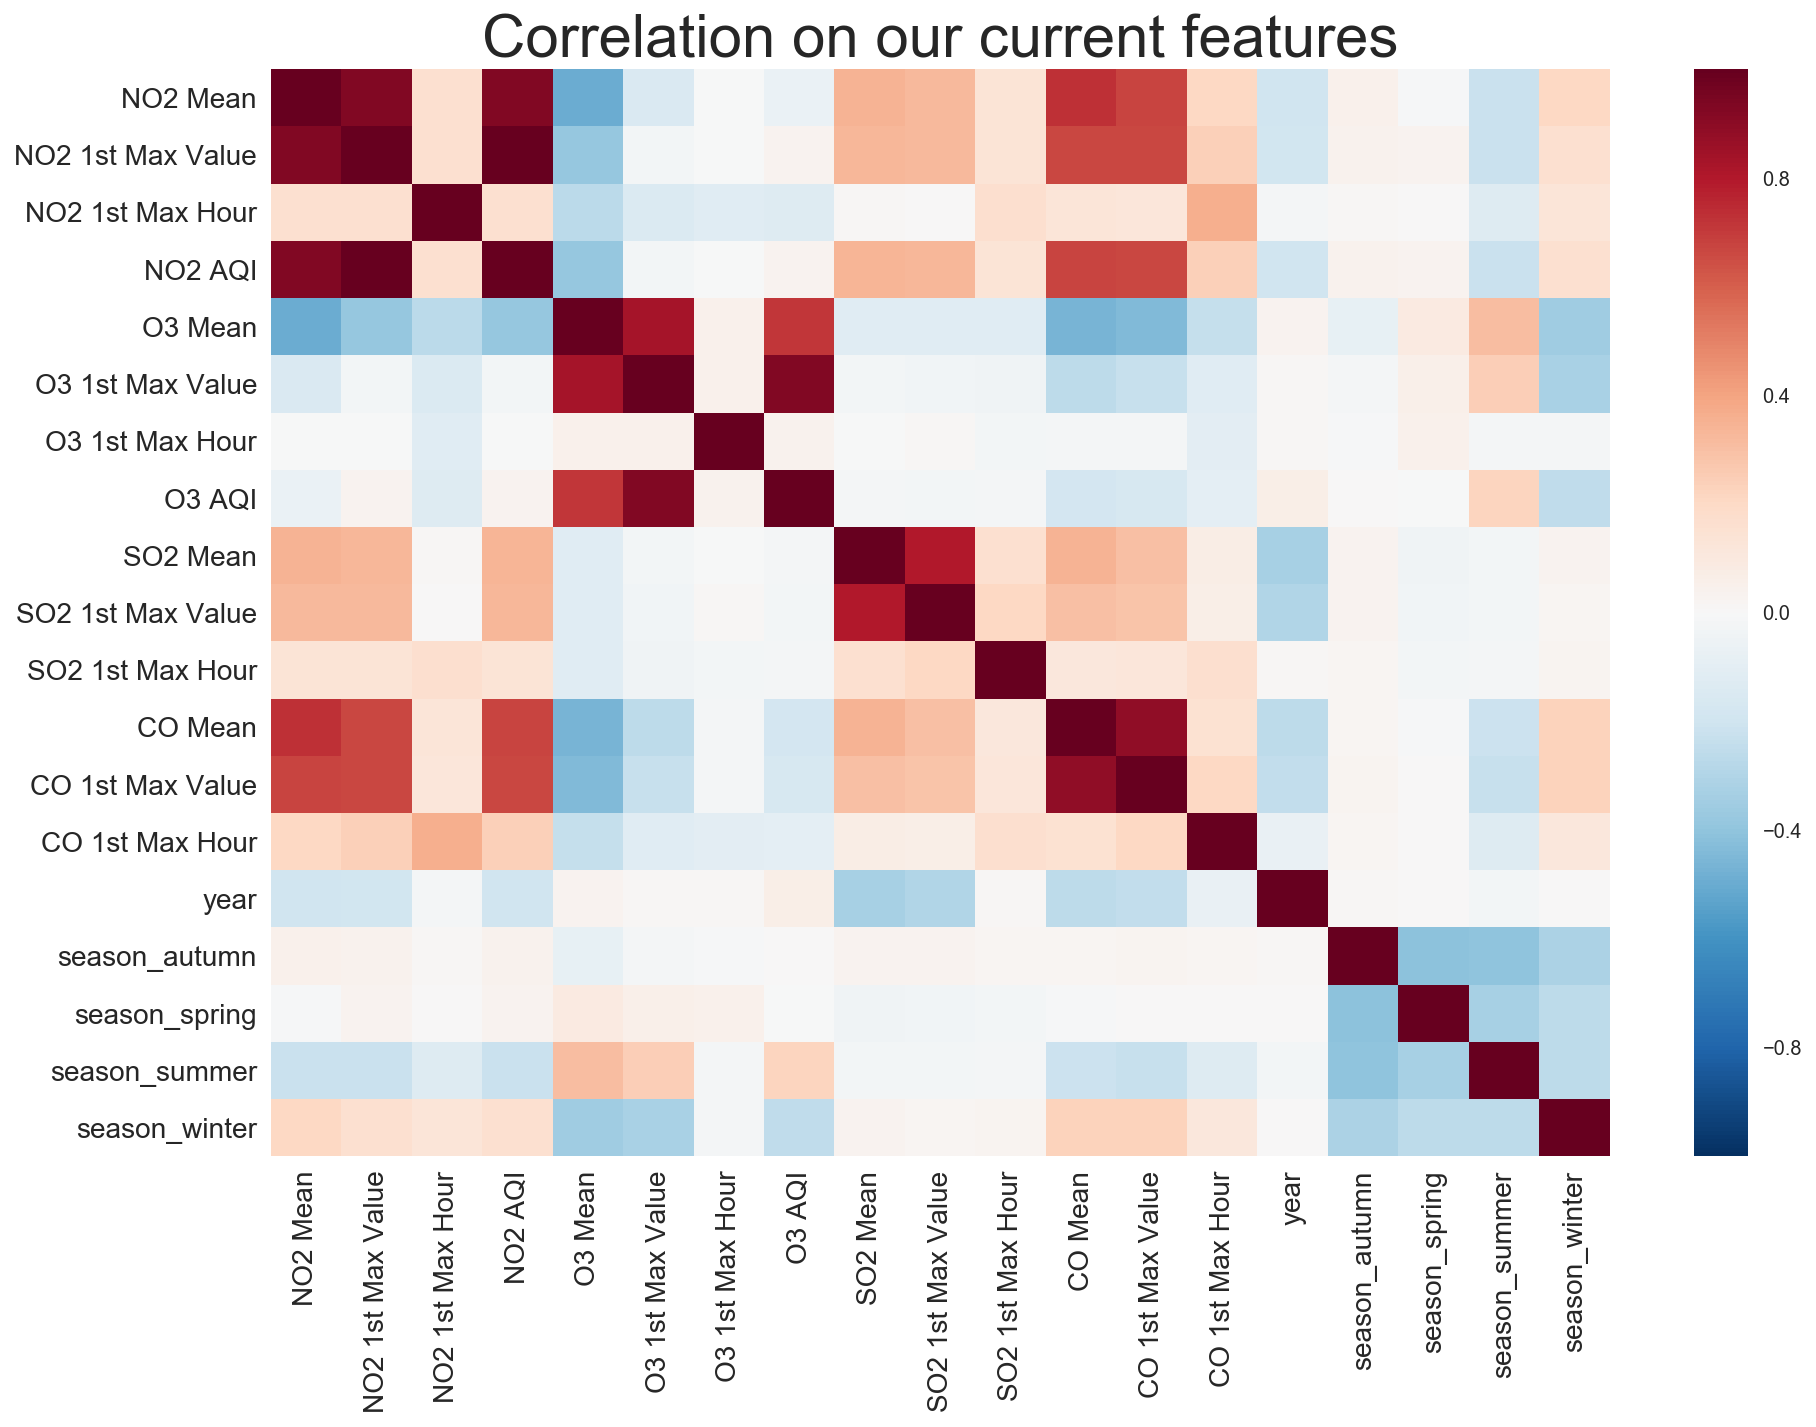

In [16]:
plt.figure(figsize=(15,10))
sns.heatmap(X.corr())
plt.title('Correlation on our current features', size = 30)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

## Principal Component Decomposition

#### As we expected there is high multi-colinearity in our feture matrix. We will use principal component analysis to reduce the correlation between features and to reduce the number of features.


In [17]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pd.DataFrame(data = pca.fit_transform(X), columns = ['pca'+str(i) for i in range(X.shape[1])])

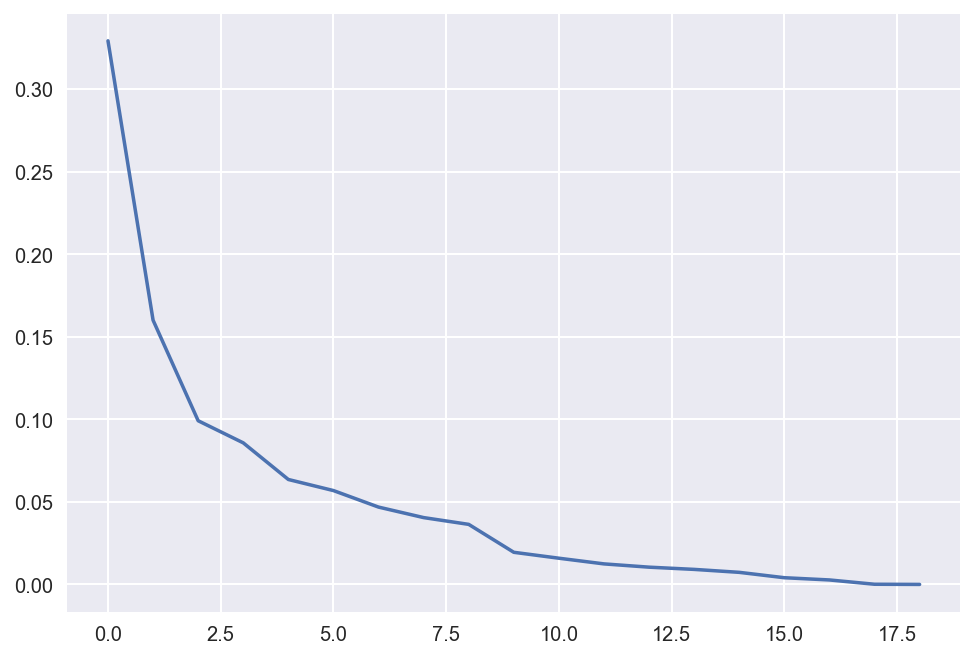

In [18]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

#### When plotting our principal component variance explained ratio, there is no clear elbow to the curve, so to help us to decide how many features to keep we have used horn's parallel analysis. From this we have decided to keep 6 principal components.


In [19]:
def horn_parallel_analysis(X, iters=3, percentile=95):
    componets = []
    for i in range(iters):
        pca = PCA()
        shape = X.shape
        fake_data = pd.DataFrame(data = np.random.normal(size=shape), columns=X.columns)
        componets.append(pca.fit(fake_data).explained_variance_)
    
    return [np.percentile([comp[j] for comp in componets] , percentile) for j in range(X.shape[1])]

var_explained_for_random_data = horn_parallel_analysis(X)

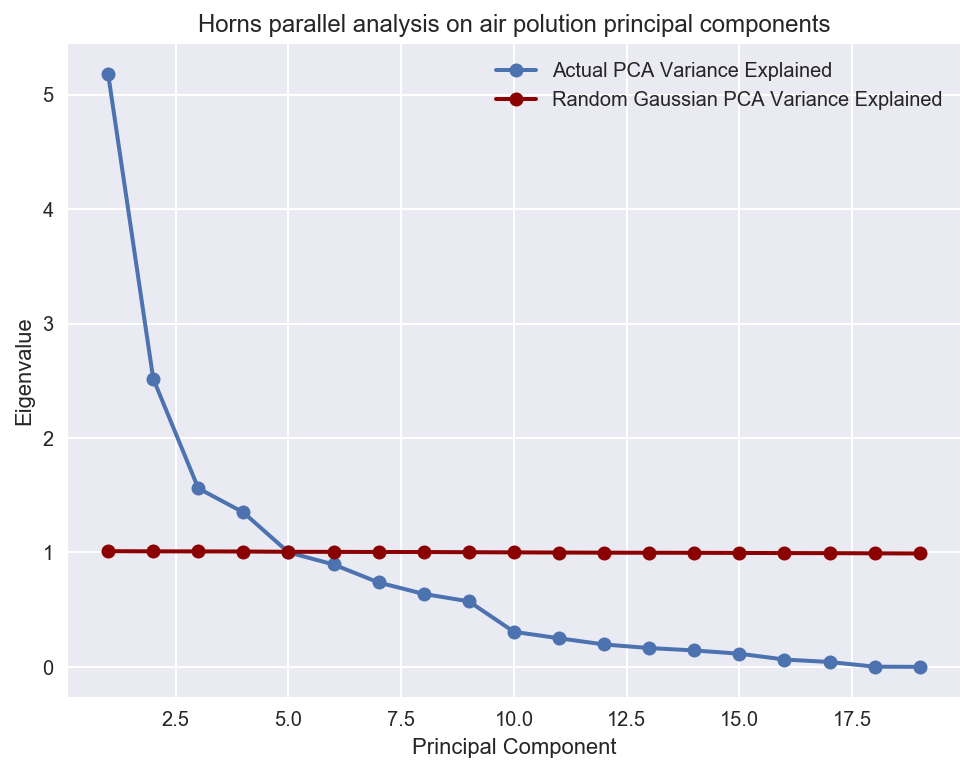

In [20]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(range(1, X.shape[1]+1), pca.explained_variance_, lw=2, marker='o')
ax.plot(range(1, X.shape[1]+1), var_explained_for_random_data, lw=2, color='darkred', marker='o')

ax.set_title("Horns parallel analysis on air polution principal components")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Eigenvalue")

plt.legend(['Actual PCA Variance Explained', "Random Gaussian PCA Variance Explained"])
plt.show()

In [21]:
X_final = X_pca[['pca0','pca1','pca2','pca3','pca4','pca5']]

In [22]:
df_pca_decomposition = pd.DataFrame({'pca'+str(i):pd.Series(pca.components_[i],X.columns) for i in range(0,6)})
df_pca_decomposition

,pca0,pca1,pca2,pca3,pca4,pca5
NO2 Mean,0.392322,0.117359,-0.176405,-0.104234,0.040285,0.057927
NO2 1st Max Value,0.380110,0.190040,-0.218411,-0.065920,0.035259,0.033845
NO2 1st Max Hour,0.113207,-0.137933,-0.203303,0.542045,-0.034948,-0.299213
NO2 AQI,0.380739,0.191488,-0.214624,-0.067086,0.030726,0.030788
O3 Mean,-0.286220,0.420661,0.003986,0.046454,-0.078658,-0.040346
O3 1st Max Value,-0.164352,0.556210,-0.154048,0.095149,-0.024557,-0.033691
O3 1st Max Hour,-0.018662,0.062654,0.061660,-0.326085,0.680134,-0.645759
O3 AQI,-0.130196,0.547790,-0.199967,0.089177,0.011331,0.016866
SO2 Mean,0.219430,0.198561,0.544619,0.129793,0.021399,0.049162
SO2 1st Max Value,0.212498,0.191036,0.551773,0.146784,0.087898,0.081989


#### The following plots help to show the importance of our original features for each on our principal components

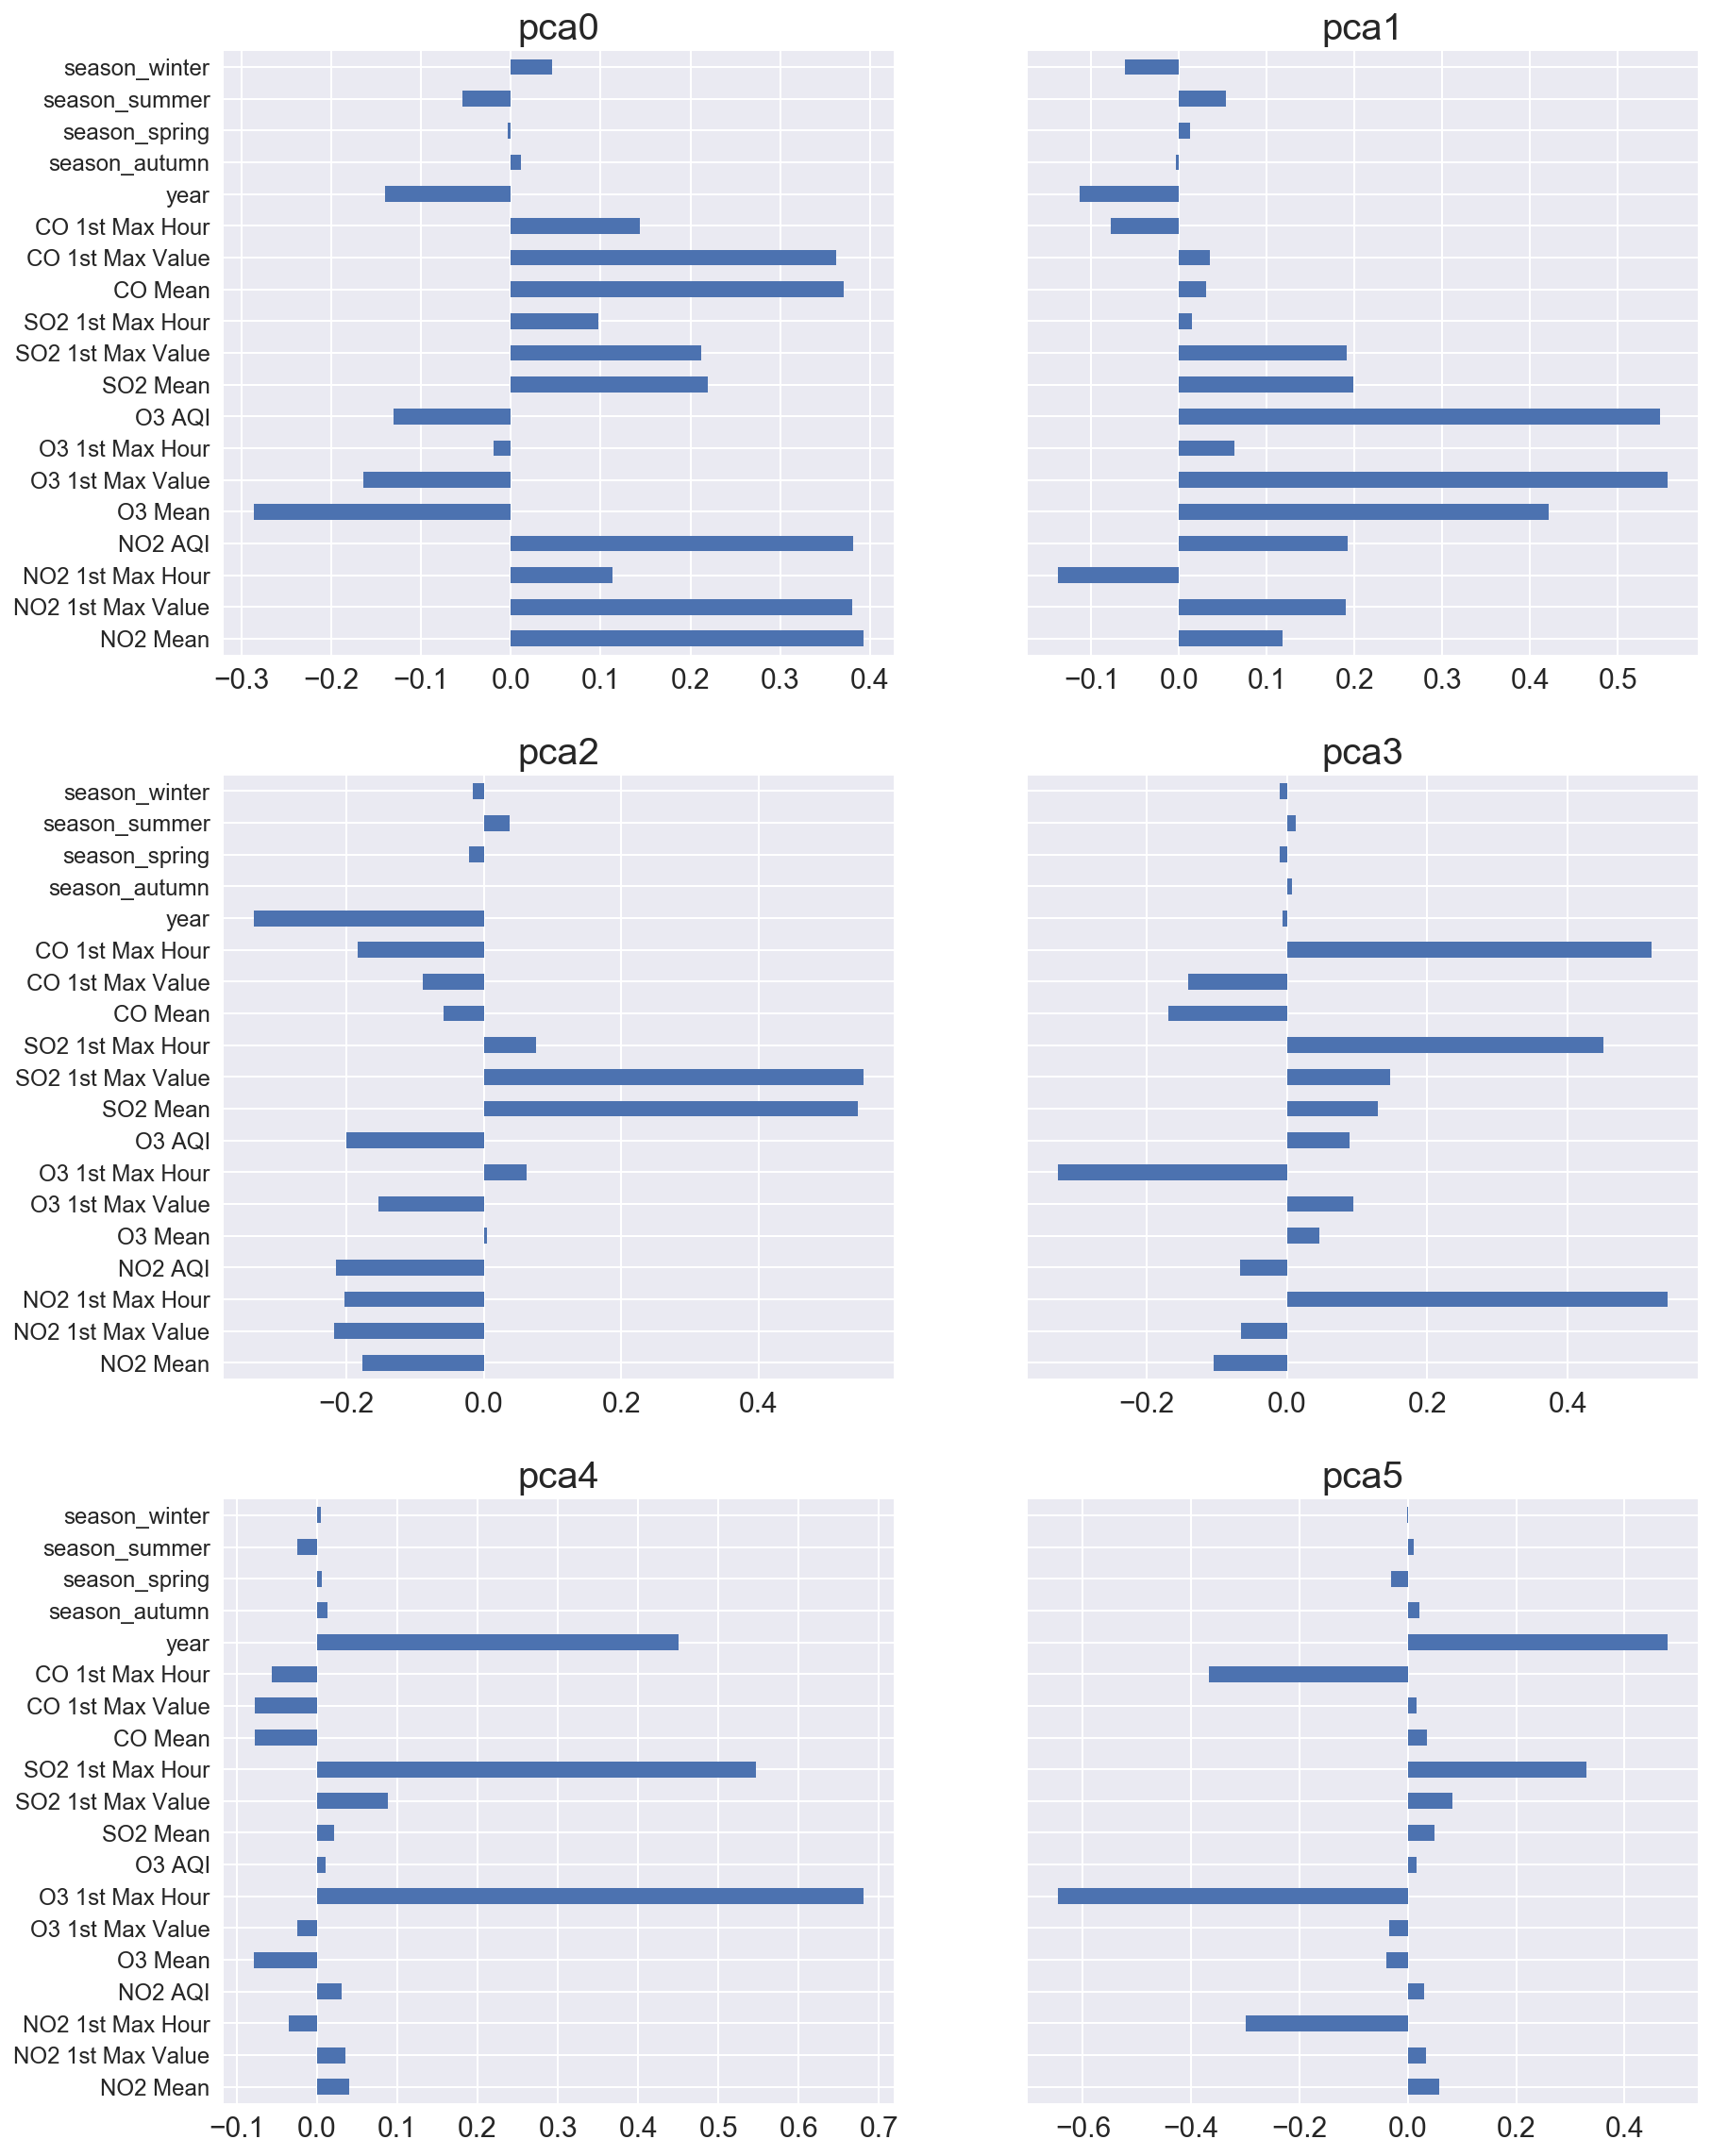

In [23]:
plt.figure(figsize=(14,20))
i = 1
for col in df_pca_decomposition.columns:
    plt.subplot(3,2,i)
    helper = df_pca_decomposition[col]
    if i%2-1 == 0:
        helper.plot(kind = 'barh', title=col)
    else:
        pd.Series(helper.values, index=['']*19).plot(kind = 'barh')
    i+=1
    plt.title(col, size= 20)
    plt.xticks(size = 15)
    plt.yticks(size = 12)
plt.tight_layout
plt.show()

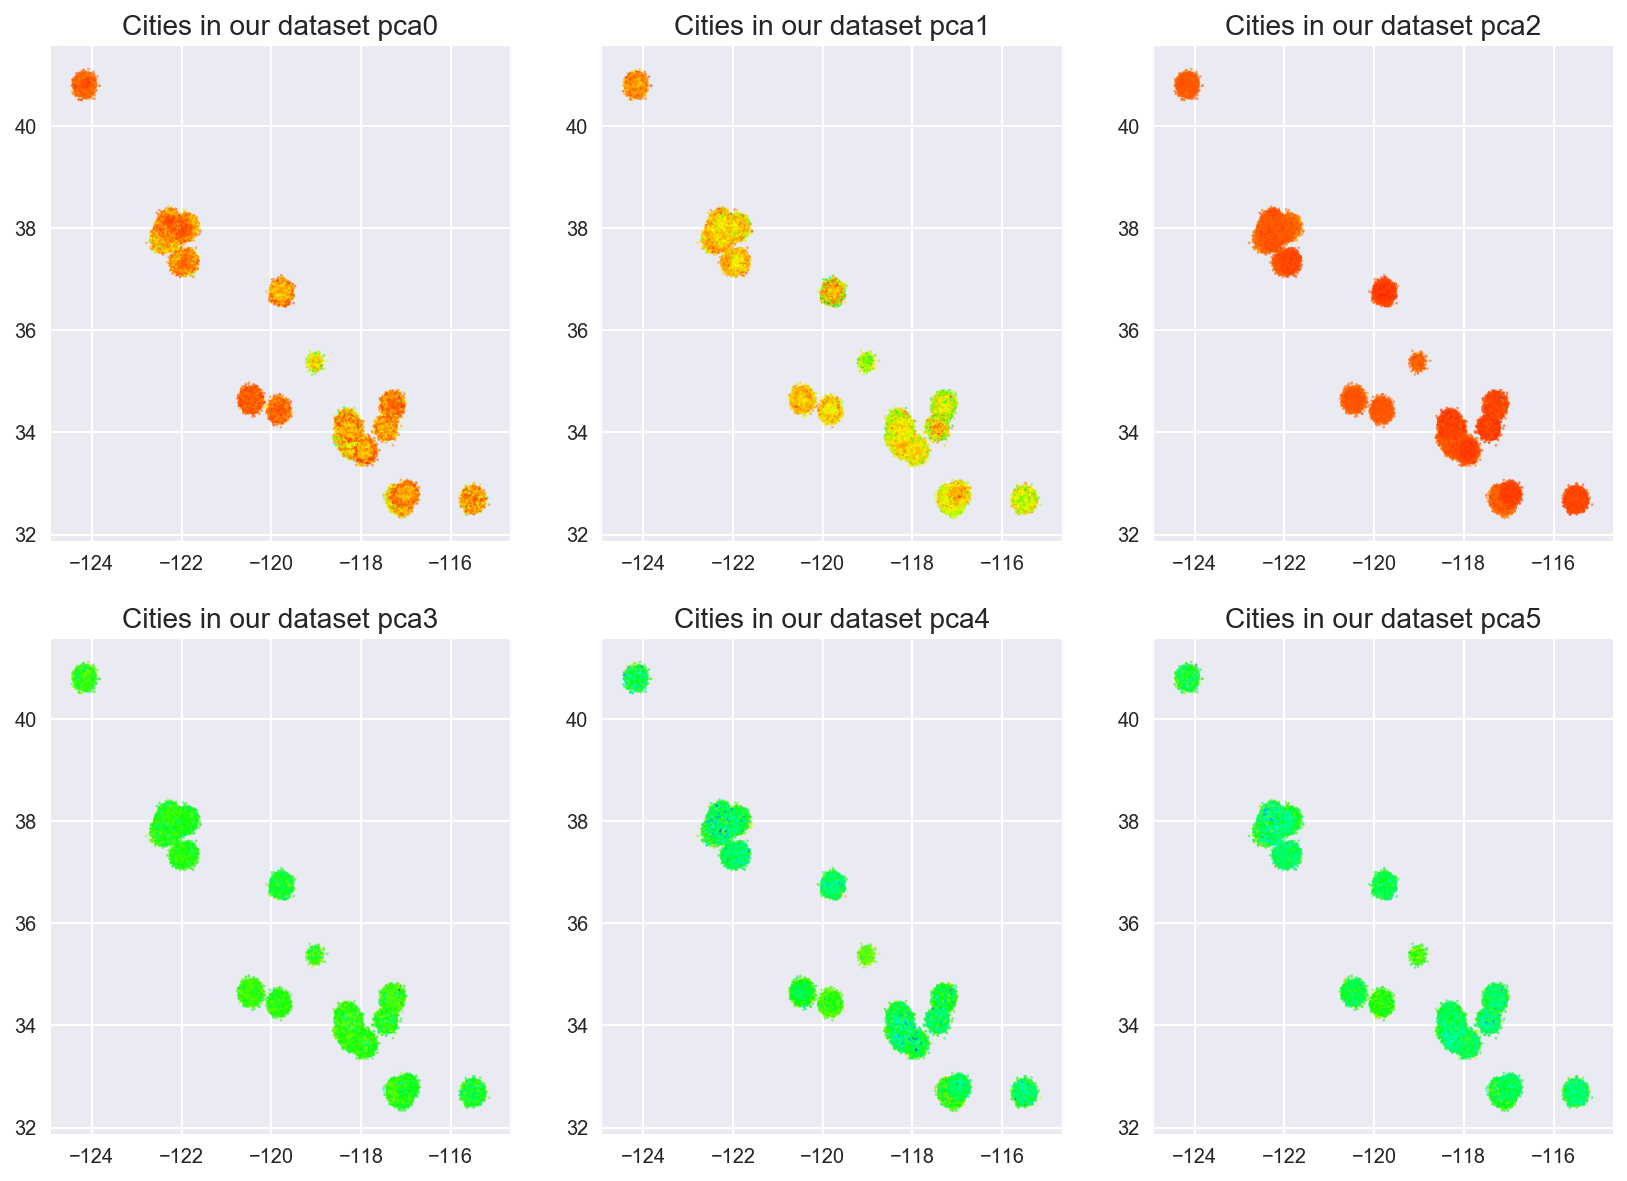

In [24]:
helper = df_california_wlocations[['Latitude','Longitude']]
helper = helper + 0.08*np.random.normal(size=helper.shape)

plt.figure(figsize=(14,10))
for i in range(0,6):
    plt.subplot(2,3,i+1)
    col = X_final.columns[i]
    plt.scatter(y=helper['Latitude'], x=helper['Longitude'], 
                c= scale_dataframe(X_final[[col]], method='MinMaxScaler')[col], 
                cmap='gist_rainbow', alpha = 0.5, s = 1)
    plt.title('Cities in our dataset '+col, size = 14)
    
plt.tight_layout
plt.show()

## Sampling

In [25]:
df_pca_and_locations = pd.concat([X_final, df_california_wlocations[['Latitude','Longitude','City']]], axis=1)
df_pca_and_locations.dropna(how='any', inplace=True)
df_sampled = df_pca_and_locations.groupby('City').apply(lambda x: x.sample(n=300))
df_sampled.head()

pca0      pca1      pca2      pca3      pca4      pca5  \
City                                                                            
Bakersfield 7067   3.402713  0.056708  0.148881  1.206455 -0.778662 -1.489173   
            42262  1.741251 -0.217122 -0.253311 -1.576083 -1.134236  0.201875   
            42267  1.990593 -0.070223 -0.287862 -0.358557 -0.840809 -0.786926   
            42311  6.213268  4.115920  3.610235 -0.023283  0.728553  1.108437   
            42382  1.809015  1.128091 -0.918265  1.355792 -0.987833 -1.816192   

                    Latitude   Longitude         City  
City                                                   
Bakersfield 7067   35.373292 -119.018711  Bakersfield  
            42262  35.373292 -119.018711  Bakersfield  
            42267  35.373292 -119.018711  Bakersfield  
            42311  35.373292 -119.018711  Bakersfield  
            42382  35.373292 -119.018711  Bakersfield

In [26]:
df_sampled.shape

(7500, 9)

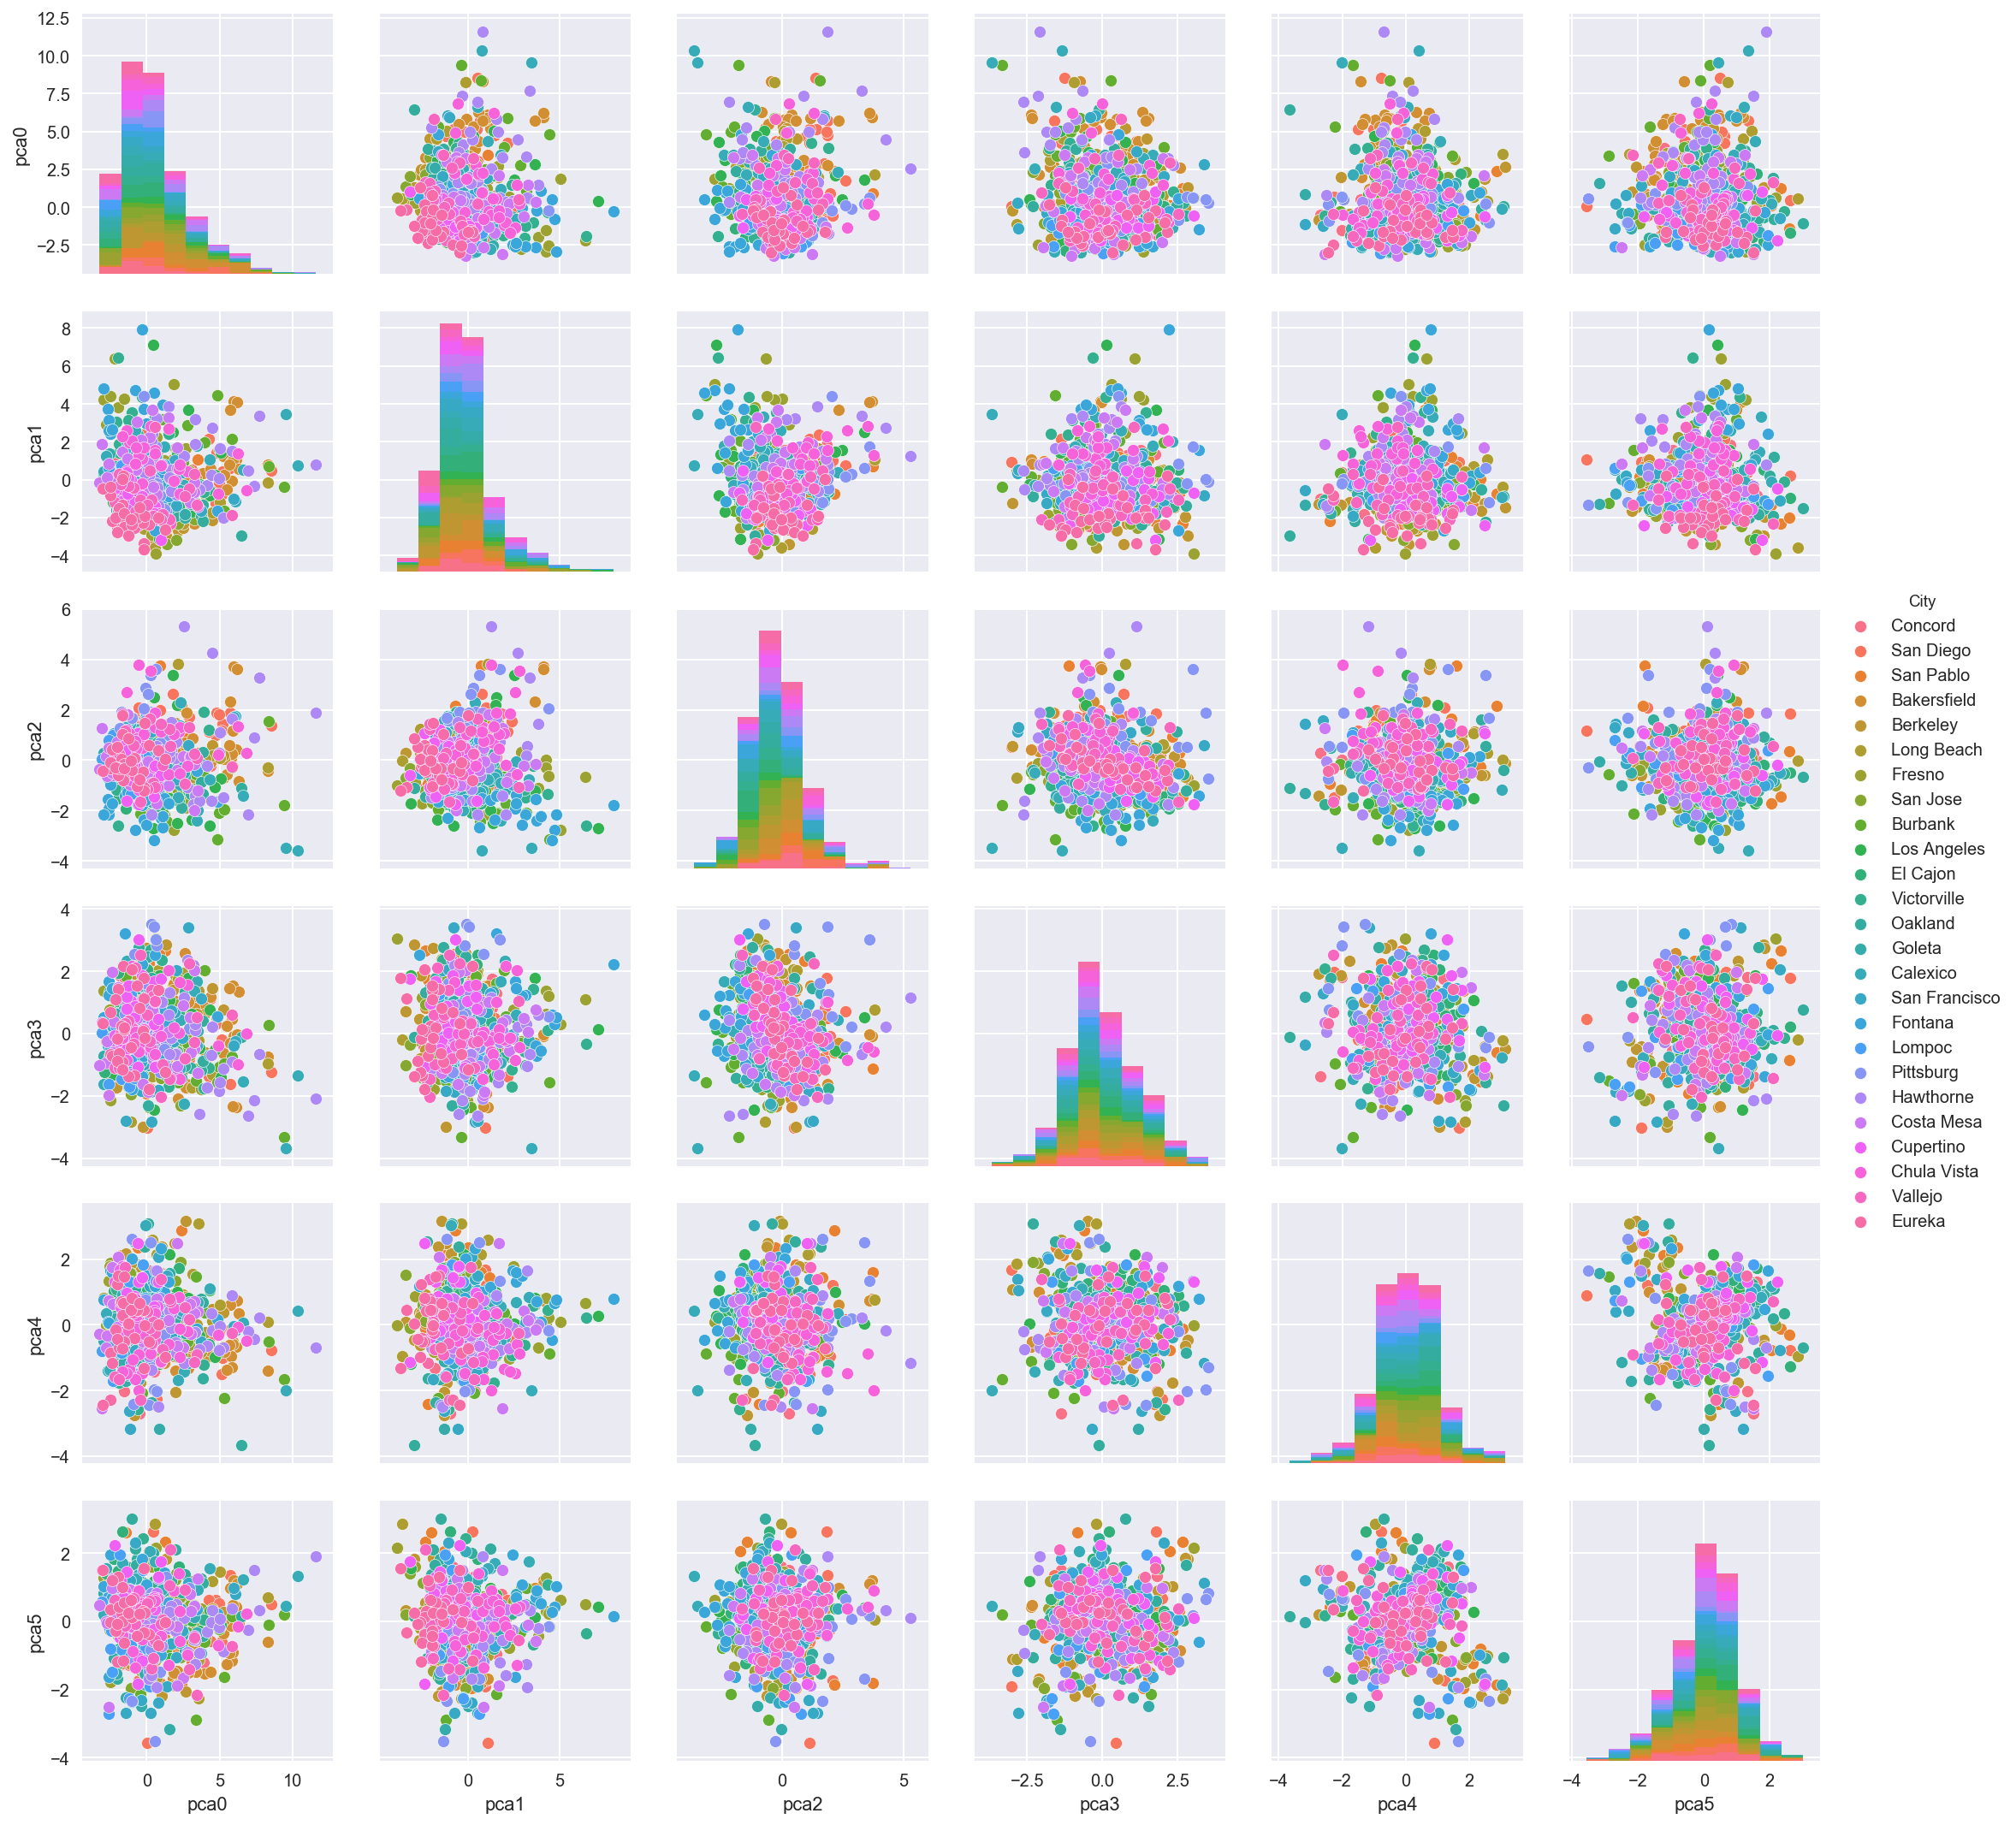

In [27]:
sns.pairplot(df_sampled.sample(frac=0.1), vars=X_final.columns, hue='City')
plt.show()

### Modeling

##### Getting the baseline

In [28]:
X = df_sampled[list(X_final.columns)]
X = pd.DataFrame(data = X.values, columns = X.columns)
y_city = df_sampled['City']

In [29]:
X.head()

,pca0,pca1,pca2,pca3,pca4,pca5
0,3.402713,0.056708,0.148881,1.206455,-0.778662,-1.489173
1,1.741251,-0.217122,-0.253311,-1.576083,-1.134236,0.201875
2,1.990593,-0.070223,-0.287862,-0.358557,-0.840809,-0.786926
3,6.213268,4.115920,3.610235,-0.023283,0.728553,1.108437
4,1.809015,1.128091,-0.918265,1.355792,-0.987833,-1.816192


In [30]:
(y_city.value_counts()/y_city.count())

El Cajon         0.04
Pittsburg        0.04
Los Angeles      0.04
San Diego        0.04
Eureka           0.04
Bakersfield      0.04
Burbank          0.04
Costa Mesa       0.04
Vallejo          0.04
San Francisco    0.04
Hawthorne        0.04
Chula Vista      0.04
Calexico         0.04
Cupertino        0.04
Lompoc           0.04
San Jose         0.04
Fontana          0.04
Goleta           0.04
Oakland          0.04
San Pablo        0.04
Victorville      0.04
Fresno           0.04
Long Beach       0.04
Berkeley         0.04
Concord          0.04
Name: City, dtype: float64

### Applying logistic regression to principal components

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
np.random.seed = 2001
lr = LogisticRegression()

Xtr, Xte, ytr, yte = train_test_split(X, y_city, test_size = 0.2)

In [32]:
print('Acc of Logistic Regression (default settings):')
lr.fit(Xtr,ytr).score(Xte,yte)

Acc of Logistic Regression (default settings):


0.25933333333333336

In [33]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import homogeneity_completeness_v_measure

resu = []
for i in np.linspace(0.1,3,30):
    for j in range(1,5,1):
        dbsc = DBSCAN(eps=i, min_samples=j)

        dbscan_predictions = dbsc.fit_predict(X)
        h,c,v = homogeneity_completeness_v_measure(y_city,dbscan_predictions)
        k = [i,j,h,c,v]
        resu.append(k)

In [34]:
pd.DataFrame(resu, columns=['epsilon','min_neighbors',
                            'homogeneity','compleatness',
                            'v_score']).sort_values('v_score', ascending = False).head()

,epsilon,min_neighbors,homogeneity,compleatness,v_score
4,0.2,1,0.999289,0.361143,0.530546
0,0.1,1,1.000000,0.360932,0.530419
8,0.3,1,0.995103,0.360893,0.529685
12,0.4,1,0.975179,0.357956,0.523684
16,0.5,1,0.901795,0.350150,0.504436


In [35]:
optimal_dbscan = DBSCAN(eps=0.2, min_samples=1)
cluster_membership = optimal_dbscan.fit_predict(X)

In [36]:
X_dbscan = pd.DataFrame(data = X.values, columns = X.columns)
X_dbscan['cluster_membership'] = cluster_membership
X_dbscan.head()

,pca0,pca1,pca2,pca3,pca4,pca5,cluster_membership
0,3.402713,0.056708,0.148881,1.206455,-0.778662,-1.489173,0
1,1.741251,-0.217122,-0.253311,-1.576083,-1.134236,0.201875,1
2,1.990593,-0.070223,-0.287862,-0.358557,-0.840809,-0.786926,2
3,6.213268,4.115920,3.610235,-0.023283,0.728553,1.108437,3
4,1.809015,1.128091,-0.918265,1.355792,-0.987833,-1.816192,4


## Tunning our models on a training set

In [37]:
Xtr, Xte, ytr, yte = train_test_split(scale_dataframe(X_dbscan, method='MinMaxScaler'), y_city, test_size = 0.2)

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
def model_tester(X,y,names, models, parameters, q = False, verb = 0):
    dict_of_models = {}
    
    for name, model, param in zip(names, models, parameters):
        if q: param = {}
        gs = GridSearchCV(model, param_grid=param, cv=3, verbose=verb)
        gs.fit(X, y)
        score = accuracy_score(y, cross_val_predict(gs.best_estimator_, X, y))
        dict_of_models[name] = gs
        print ((name+ ' acc score:').ljust(14), score)
    return dict_of_models

model_names =['LogisticRegression','RandomForest']
models = [LogisticRegression(), RandomForestClassifier()]

lr_params = {'penalty': ['l1'], 'C': np.logspace(-3, 3, 7)}
rf_params = {'max_features': [0.5], 'n_estimators':[100]}

svc_params = {'C': np.logspace(-4, 4, 3),'kernel':['linear', 'poly', 'rbf']}

params = [lr_params, rf_params]

results = model_tester(Xte, yte, model_names,models,params, q=True, verb = 0)

LogisticRegression acc score: 0.33
RandomForest acc score: 0.685333333333


## Evaluating our optimized models on the test data (Final Results)

In [39]:
results['LogisticRegression'].best_estimator_.fit(Xtr,ytr).score(Xte,yte)

0.48533333333333334

In [40]:
results['RandomForest'].best_estimator_.fit(Xtr,ytr).score(Xte,yte)

0.87333333333333329